# Somatic vs non-somatic classification

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [45]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
method_summary = Summary()

## Get the data

In [46]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

In [47]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [48]:
# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
get_table(impact.is_artefact)

,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [49]:
# choose label
label = 'is_artefact'

# choose features
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']
impact = impact[features + [label]].dropna()
    
# transform categorical features
categorical_features = ['VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP', 'gene_type']
numerical_features = [f for f in features if not f in categorical_features]
impact = pd.get_dummies(impact, columns=categorical_features, sparse=True)

# get reduced dataset
positive_class_number = impact[impact.is_artefact].shape[0]
impact = pd.concat([impact[impact.is_artefact],
                    impact[~impact.is_artefact].iloc[:positive_class_number]], ignore_index=True)

# shuffle data
rng = np.random.RandomState(42)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]
impact.reset_index(drop=True, inplace=True)

# get features matrix X (n_samples x n_features) and target array y (n_samples)
X = impact.drop(label, axis=1)
X = X.astype(float)
y = impact[label]

print(X.shape)
print(y.shape)
get_table(y)

(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


In [50]:
X.head()

,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,sample_coverage,frequency_in_normals,VEP_COSMIC_CNT,VEP_gnomAD_AF,VEP_gnomAD_total_AF_AFR,VEP_gnomAD_total_AF_AMR,VEP_gnomAD_total_AF_ASJ,VEP_gnomAD_total_AF_EAS,VEP_gnomAD_total_AF_FIN,VEP_gnomAD_total_AF_NFE,VEP_gnomAD_total_AF_OTH,VEP_gnomAD_total_AF_max,VEP_gnomAD_total_AF,Kaviar_AF,VEP_Consequence_frameshift_variant,VEP_Consequence_inframe_deletion,VEP_Consequence_inframe_insertion,VEP_Consequence_missense_variant,VEP_Consequence_splice_acceptor_variant,VEP_Consequence_splice_donor_variant,VEP_Consequence_start_lost,VEP_Consequence_stop_gained,VEP_Consequence_stop_lost,VEP_VARIANT_CLASS_SNV,VEP_VARIANT_CLASS_deletion,VEP_VARIANT_CLASS_indel,VEP_VARIANT_CLASS_insertion,VEP_VARIANT_CLASS_substitution,VEP_IMPACT_HIGH,VEP_IMPACT_MODERATE,VEP_CLIN_SIG_benign,VEP_CLIN_SIG_pathogenic,VEP_CLIN_SIG_unknown,VEP_in_dbSNP_False,VEP_in_dbSNP_True,gene_type_oncogene,gene_type_oncogene_and_tsg,gene_type_tsg,gene_type_unknown
0,846.0,0.56619,479.0,833.0,0.00120,1.0,1120.0,0.000,0.0,0.001541,0.000416,0.000204,0.000000,0.000000,0.004078,0.002370,0.001241,0.004078,0.001747,0.001753,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,718.0,0.30641,220.0,768.0,0.00781,6.0,923.0,0.179,11.0,0.094380,0.019823,0.060354,0.115284,0.064002,0.145893,0.113203,0.109593,0.145893,0.096063,0.000259,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,417.0,0.19904,83.0,481.0,0.00000,0.0,548.0,0.000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,71.0,0.14085,10.0,219.0,0.00000,0.0,87.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,658.0,0.05471,36.0,295.0,0.00000,0.0,540.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [8]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Dummy

### Uniform

Generates predictions uniformly at random, expected accuracy: 0.5 | expected AUC: 0.5.

In [9]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='uniform', random_state=42)

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (0.37s)
▴ Mean accuracy         : 0.499 ± 0.006
▴ Mean f1               : 0.497 ± 0.006
▴ Mean roc_auc          : 0.500 ± 0.000
▴ Mean average_precision: 0.500 ± 0.000


In [10]:
metrics.print_fold_details()

Fold #: [fit_time | score_time]
  → score_name_1: [test_score_1 | train_score_1]
  → score_name_2: [test_score_2 | train_score_2]
  → ...

Fold 1: [0.03s | 0.00s]
  → accuracy         : [0.501 | 0.505]
  → f1               : [0.499 | 0.504]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 2: [0.03s | 0.00s]
  → accuracy         : [0.496 | 0.506]
  → f1               : [0.494 | 0.506]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 3: [0.03s | 0.00s]
  → accuracy         : [0.492 | 0.506]
  → f1               : [0.490 | 0.505]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 4: [0.03s | 0.00s]
  → accuracy         : [0.508 | 0.504]
  → f1               : [0.506 | 0.504]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 5: [0.03s | 0.00s]
  → accuracy         : [0.500 | 0.505]
  → f1               : [0.498 | 0.505]
  → roc_auc          : [0.500 | 0.500]


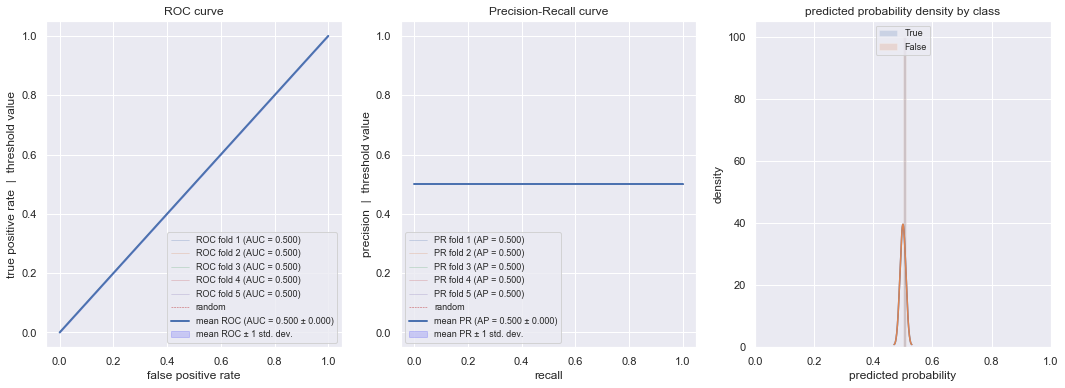

In [11]:
metrics.plot_threshold_decision_curves(figsize=(18, 6), plot_thresholds=False)

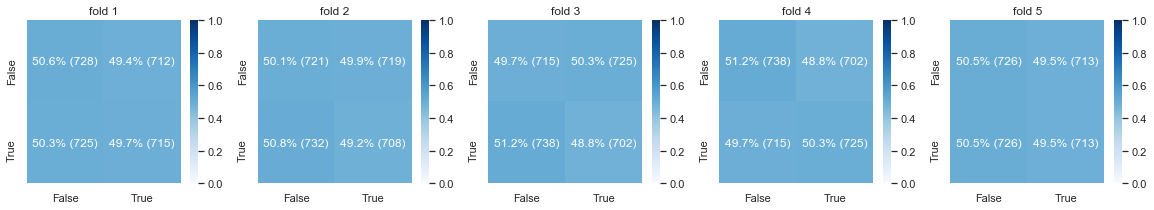

In [12]:
metrics.plot_confusion_matrix()

Run learning curves computation... done! (1.25s)


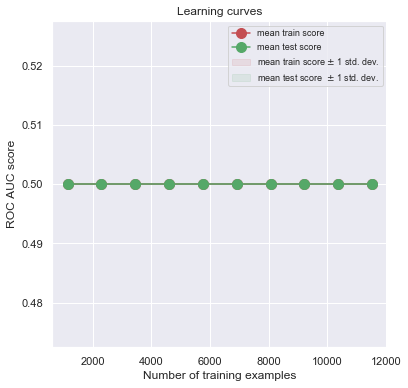

In [13]:
#plot_learning_curves(model, X, y, cv_strategy, figsize=(6, 6))

In [14]:
method_summary.add(metrics, 'Uniform', 'mediumseagreen')

### Most Frequent

Always predicts the most frequent label in the training set → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

In [21]:
model = DummyClassifier(strategy='most_frequent', random_state=42)

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model...

/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/guilminp/anaconda3/lib/python3.6/site-pac

 done! (0.36s)
▴ Mean accuracy         : 0.500 ± 0.000
▴ Mean f1               : 0.000 ± 0.000
▴ Mean roc_auc          : 0.500 ± 0.000
▴ Mean average_precision: 0.500 ± 0.000


In [22]:
metrics.print_fold_details()

Fold #: [fit_time | score_time]
  → score_name_1: [test_score_1 | train_score_1]
  → score_name_2: [test_score_2 | train_score_2]
  → ...

Fold 1: [0.03s | 0.00s]
  → accuracy         : [0.500 | 0.500]
  → f1               : [0.000 | 0.000]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 2: [0.03s | 0.00s]
  → accuracy         : [0.500 | 0.500]
  → f1               : [0.000 | 0.000]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 3: [0.03s | 0.00s]
  → accuracy         : [0.500 | 0.500]
  → f1               : [0.000 | 0.000]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 4: [0.03s | 0.00s]
  → accuracy         : [0.500 | 0.500]
  → f1               : [0.000 | 0.000]
  → roc_auc          : [0.500 | 0.500]
  → average_precision: [0.500 | 0.500]
Fold 5: [0.03s | 0.00s]
  → accuracy         : [0.500 | 0.500]
  → f1               : [0.000 | 0.000]
  → roc_auc          : [0.500 | 0.500]


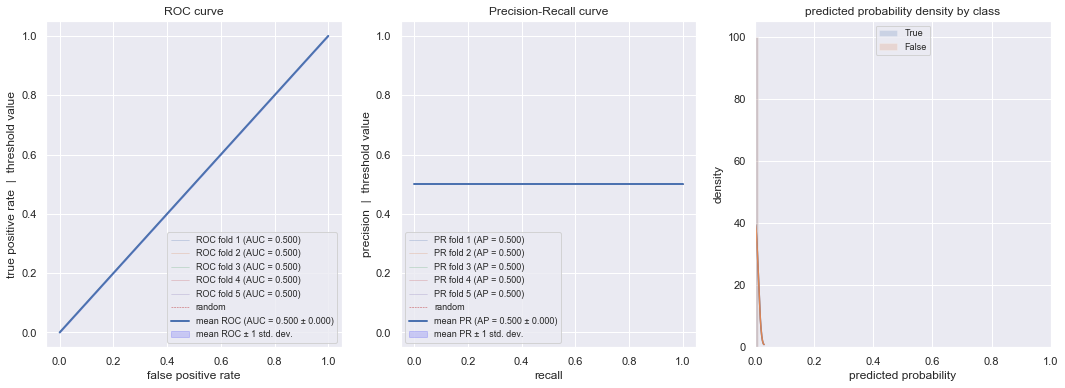

In [23]:
metrics.plot_threshold_decision_curves(figsize=(18, 6), plot_thresholds=False)

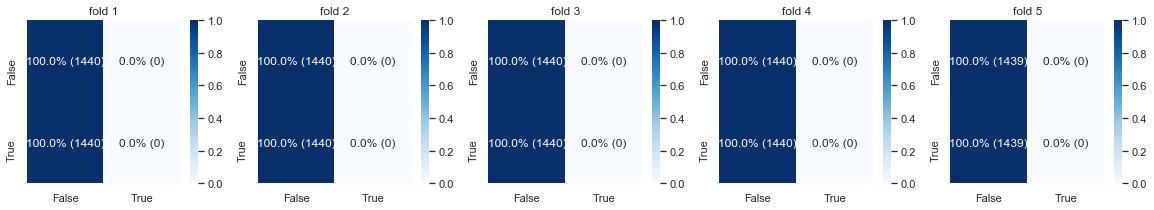

In [24]:
metrics.plot_confusion_matrix()

Run learning curves computation... done! (1.14s)


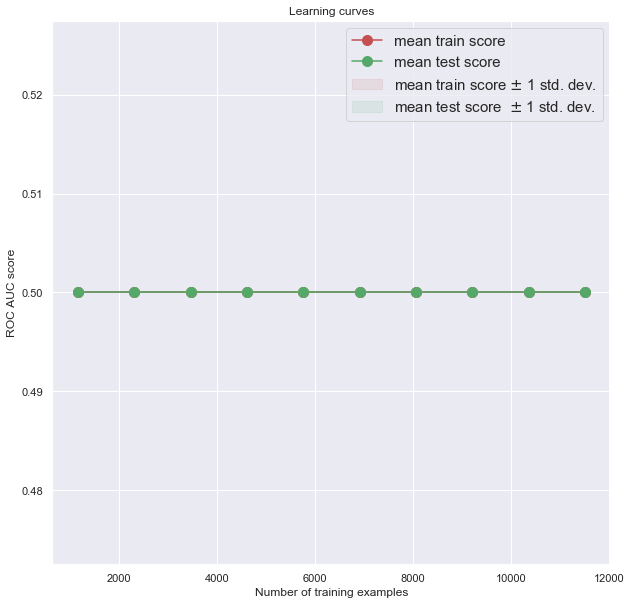

In [25]:
#plot_learning_curves(model, X, y, cv_strategy)

In [26]:
method_summary.add(metrics, 'MostFrequent', 'seagreen')

## Gaussian Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', GaussianNB())])

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (0.88s)
▴ Mean accuracy         : 0.721 ± 0.011
▴ Mean f1               : 0.619 ± 0.022
▴ Mean roc_auc          : 0.850 ± 0.009
▴ Mean average_precision: 0.872 ± 0.008


In [28]:
metrics.print_fold_details()

Fold #: [fit_time | score_time]
  → score_name_1: [test_score_1 | train_score_1]
  → score_name_2: [test_score_2 | train_score_2]
  → ...

Fold 1: [0.06s | 0.02s]
  → accuracy         : [0.710 | 0.718]
  → f1               : [0.598 | 0.612]
  → roc_auc          : [0.838 | 0.853]
  → average_precision: [0.864 | 0.874]
Fold 2: [0.05s | 0.02s]
  → accuracy         : [0.713 | 0.717]
  → f1               : [0.603 | 0.611]
  → roc_auc          : [0.854 | 0.853]
  → average_precision: [0.878 | 0.873]
Fold 3: [0.06s | 0.02s]
  → accuracy         : [0.722 | 0.716]
  → f1               : [0.623 | 0.610]
  → roc_auc          : [0.859 | 0.851]
  → average_precision: [0.871 | 0.870]
Fold 4: [0.06s | 0.02s]
  → accuracy         : [0.722 | 0.714]
  → f1               : [0.618 | 0.606]
  → roc_auc          : [0.855 | 0.850]
  → average_precision: [0.881 | 0.870]
Fold 5: [0.06s | 0.02s]
  → accuracy         : [0.738 | 0.742]
  → f1               : [0.654 | 0.657]
  → roc_auc          : [0.846 | 0.860]


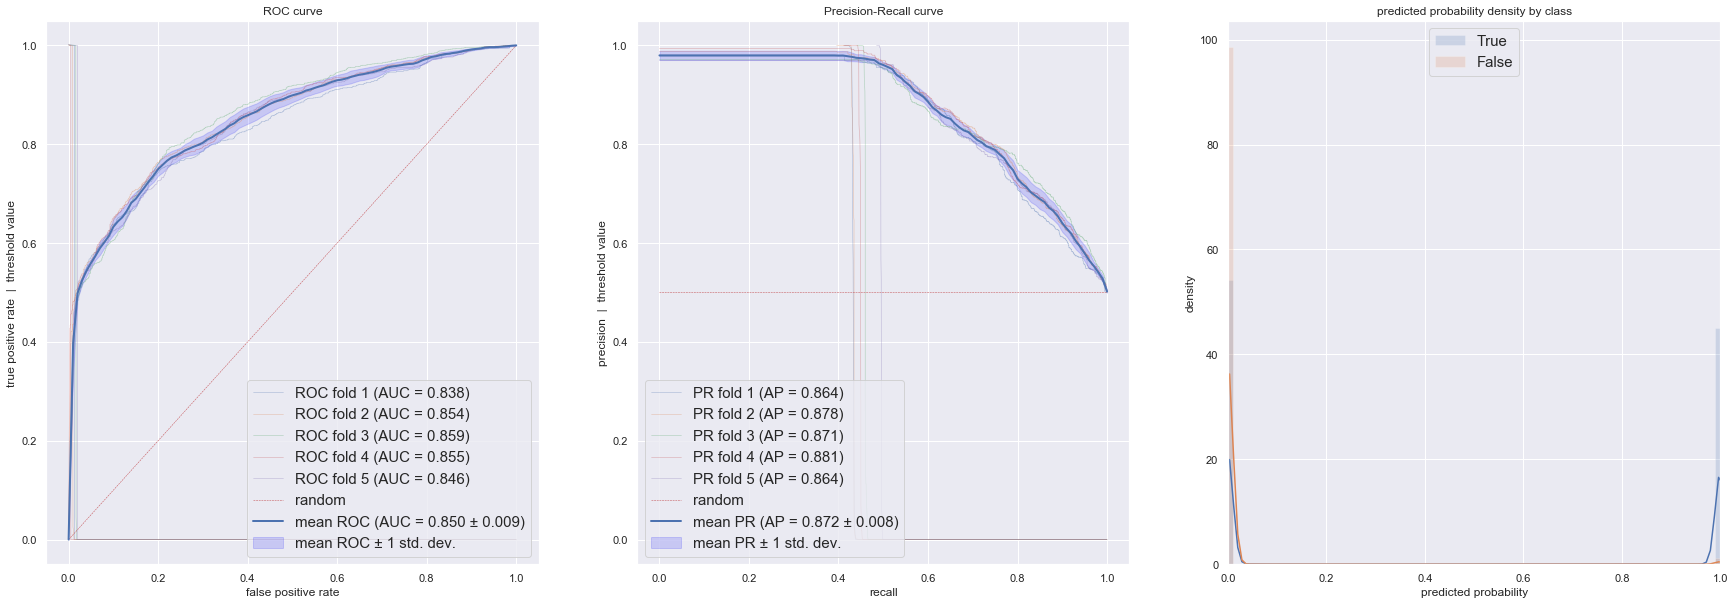

In [29]:
metrics.plot_threshold_decision_curves()

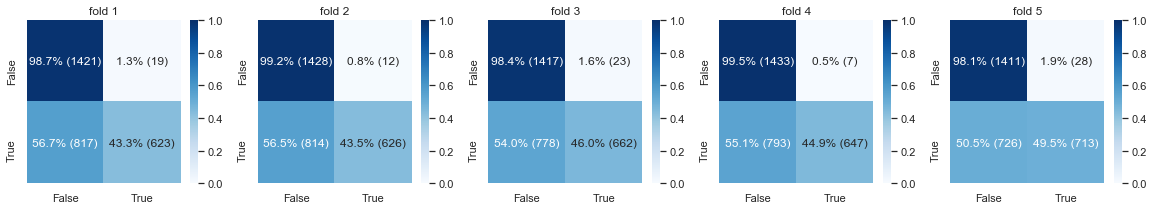

In [30]:
metrics.plot_confusion_matrix()

Run learning curves computation... done! (2.64s)


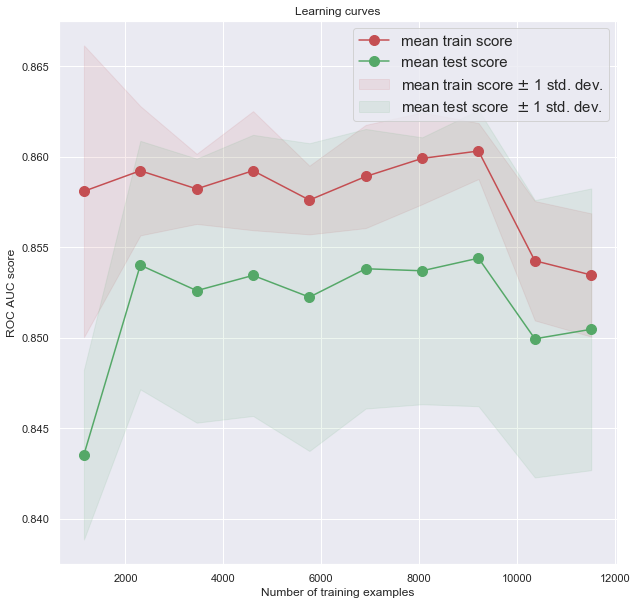

In [31]:
#plot_learning_curves(model, X, y, cv_strategy, n_jobs=5)

In [32]:
method_summary.add(metrics, 'GausssianNaiveBayes', 'darkgoldenrod')

## Logistic Regression

### Ridge regression (L2 regularization)

#### Run the model

This model performs an automatic grid search over its parameters.

In [34]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)
metrics.print_mean()

Run model... done! (3.33s)
▴ Mean accuracy         : 0.820 ± 0.003
▴ Mean f1               : 0.803 ± 0.005
▴ Mean roc_auc          : 0.891 ± 0.005
▴ Mean average_precision: 0.912 ± 0.003


In [35]:
metrics.print_fold_details()

Fold #: [fit_time | score_time]
  → score_name_1: [test_score_1 | train_score_1]
  → score_name_2: [test_score_2 | train_score_2]
  → ...

Fold 1: [2.90s | 0.03s]
  → accuracy         : [0.820 | 0.822]
  → f1               : [0.803 | 0.807]
  → roc_auc          : [0.888 | 0.895]
  → average_precision: [0.911 | 0.915]
Fold 2: [2.96s | 0.02s]
  → accuracy         : [0.815 | 0.821]
  → f1               : [0.796 | 0.806]
  → roc_auc          : [0.888 | 0.893]
  → average_precision: [0.912 | 0.914]
Fold 3: [2.94s | 0.02s]
  → accuracy         : [0.824 | 0.820]
  → f1               : [0.811 | 0.804]
  → roc_auc          : [0.899 | 0.891]
  → average_precision: [0.915 | 0.914]
Fold 4: [2.96s | 0.02s]
  → accuracy         : [0.821 | 0.821]
  → f1               : [0.803 | 0.805]
  → roc_auc          : [0.893 | 0.891]
  → average_precision: [0.916 | 0.913]
Fold 5: [2.92s | 0.02s]
  → accuracy         : [0.818 | 0.823]
  → f1               : [0.804 | 0.806]
  → roc_auc          : [0.887 | 0.894]


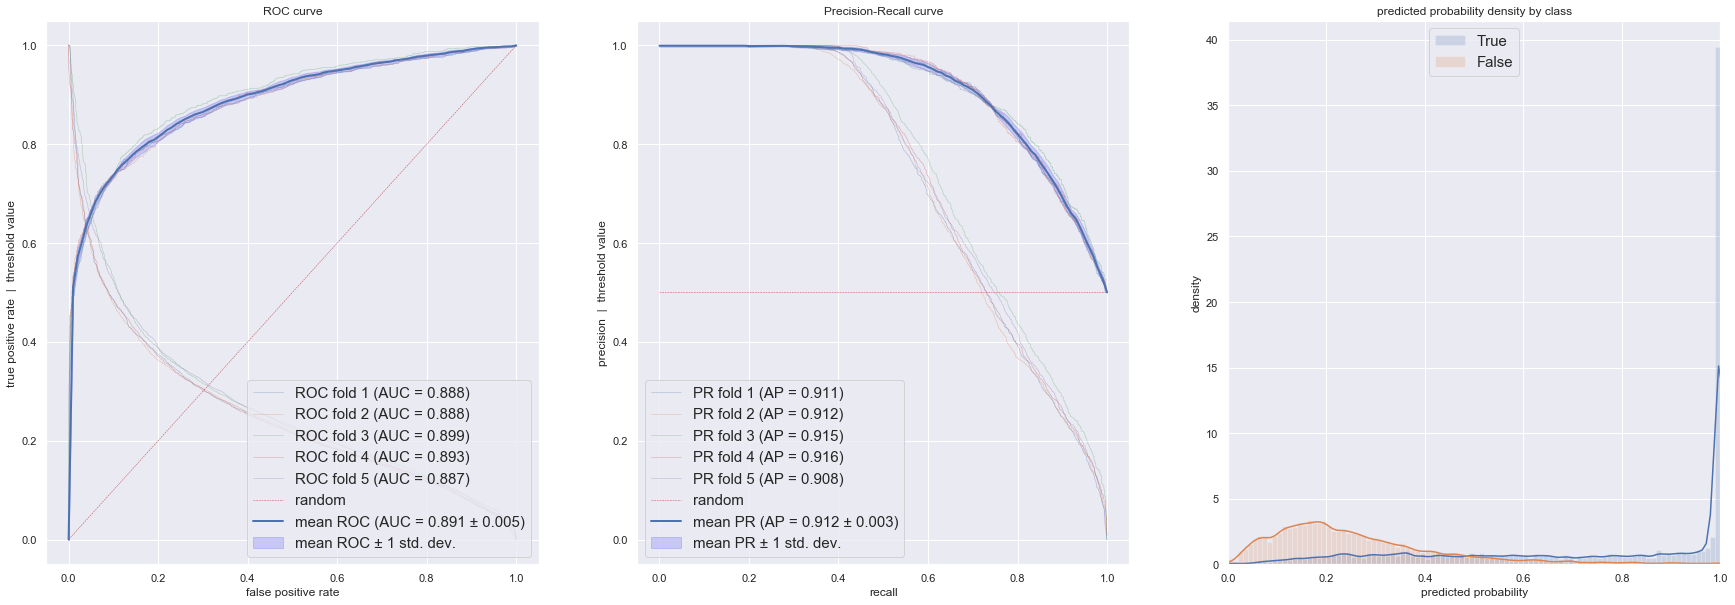

In [36]:
metrics.plot_threshold_decision_curves()

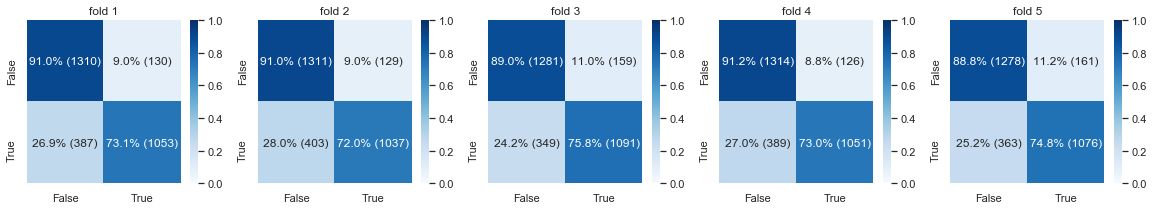

In [37]:
metrics.plot_confusion_matrix()

Run learning curves computation... done! (29.46s)


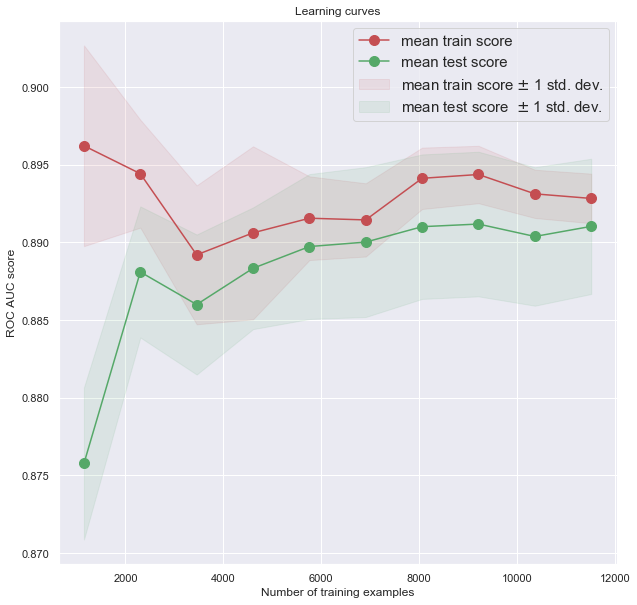

In [31]:
#plot_learning_curves(model, X, y, cv_strategy, n_jobs=5)

In [38]:
method_summary.add(metrics, 'RidgeRegression', 'salmon')

#### Study coefficients

In [33]:
model.fit(X, y);

"If your variables are positively correlated, then the coefficients will be negatively correlated, which can lead to a wrong sign on one of the coefficients.", see https://stats.stackexchange.com/questions/1580/regression-coefficients-that-flip-sign-after-including-other-predictors.

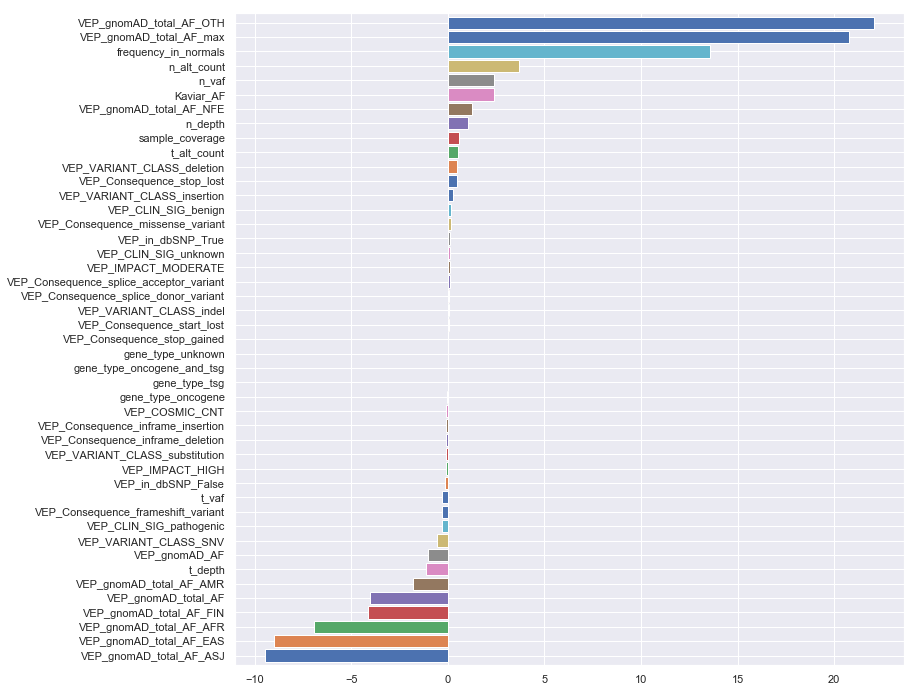

In [34]:
feature_coefficient = pd.DataFrame({'coeff': model.named_steps['classify'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85);

### Lasso regression (L1 regularization)

#### Run the model

In [39]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, penalty='l1', solver='liblinear', scoring='roc_auc', random_state=42))])

metrics = Metrics(model, X, y, cv_strategy)
metrics.print_mean()

Run model... done! (200.85s)
▴ Mean accuracy         : 0.820 ± 0.003
▴ Mean f1               : 0.804 ± 0.006
▴ Mean roc_auc          : 0.891 ± 0.005
▴ Mean average_precision: 0.912 ± 0.003


In [40]:
metrics.print_fold_details()

Fold #: [fit_time | score_time]
  → score_name_1: [test_score_1 | train_score_1]
  → score_name_2: [test_score_2 | train_score_2]
  → ...

Fold 1: [42.28s | 0.01s]
  → accuracy         : [0.820 | 0.823]
  → f1               : [0.803 | 0.808]
  → roc_auc          : [0.887 | 0.895]
  → average_precision: [0.911 | 0.915]
Fold 2: [37.20s | 0.01s]
  → accuracy         : [0.815 | 0.822]
  → f1               : [0.796 | 0.806]
  → roc_auc          : [0.888 | 0.893]
  → average_precision: [0.912 | 0.914]
Fold 3: [41.79s | 0.01s]
  → accuracy         : [0.824 | 0.821]
  → f1               : [0.811 | 0.804]
  → roc_auc          : [0.899 | 0.892]
  → average_precision: [0.915 | 0.914]
Fold 4: [34.00s | 0.01s]
  → accuracy         : [0.821 | 0.822]
  → f1               : [0.803 | 0.806]
  → roc_auc          : [0.893 | 0.891]
  → average_precision: [0.916 | 0.913]
Fold 5: [45.12s | 0.01s]
  → accuracy         : [0.819 | 0.823]
  → f1               : [0.805 | 0.806]
  → roc_auc          : [0.887 | 0.

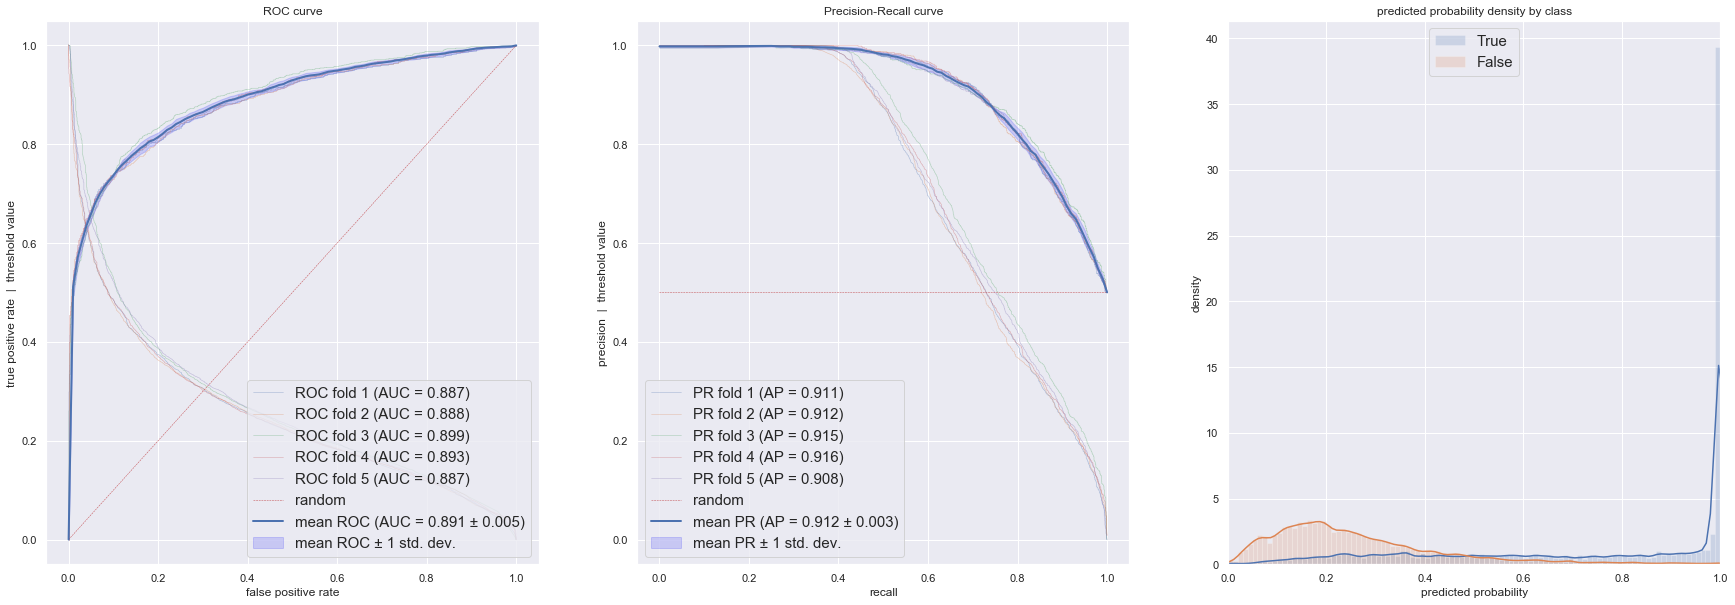

In [41]:
metrics.plot_threshold_decision_curves()

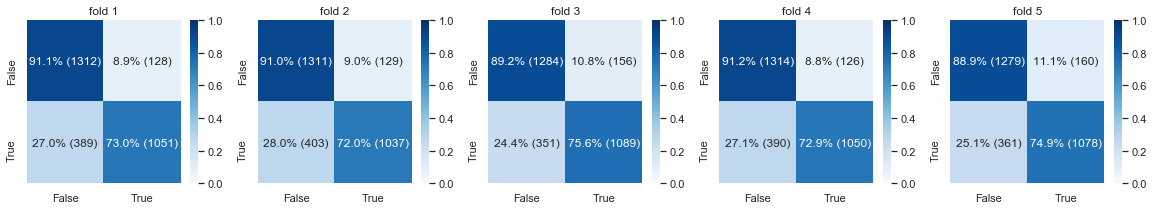

In [42]:
metrics.plot_confusion_matrix()

Run learning curves computation...

KeyboardInterrupt: 

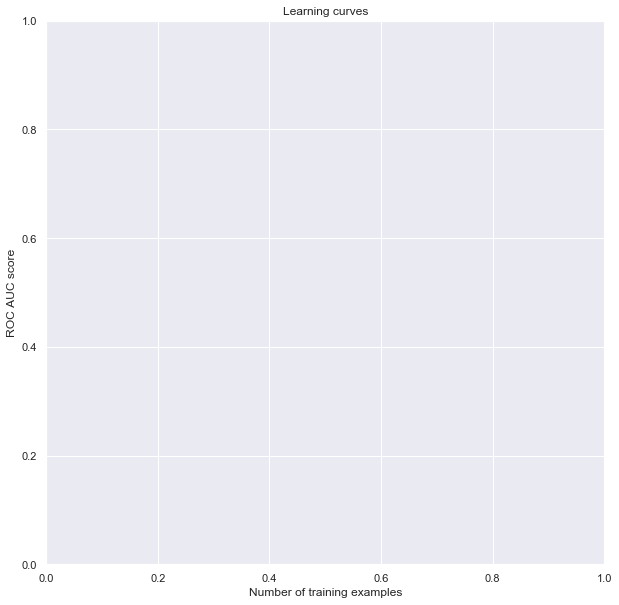

In [40]:
plot_learning_curves(model, X, y, cv_strategy, n_jobs=5)

In [43]:
method_summary.add(metrics, 'LassoRegression', 'crimson')

#### Study coefficients

We change the regularization to make it stronger (otherwise we get the same result as for the ridge regression previously):

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegression(penalty='l1', solver='liblinear', C=0.01, random_state=42))])
model.fit(X, y);

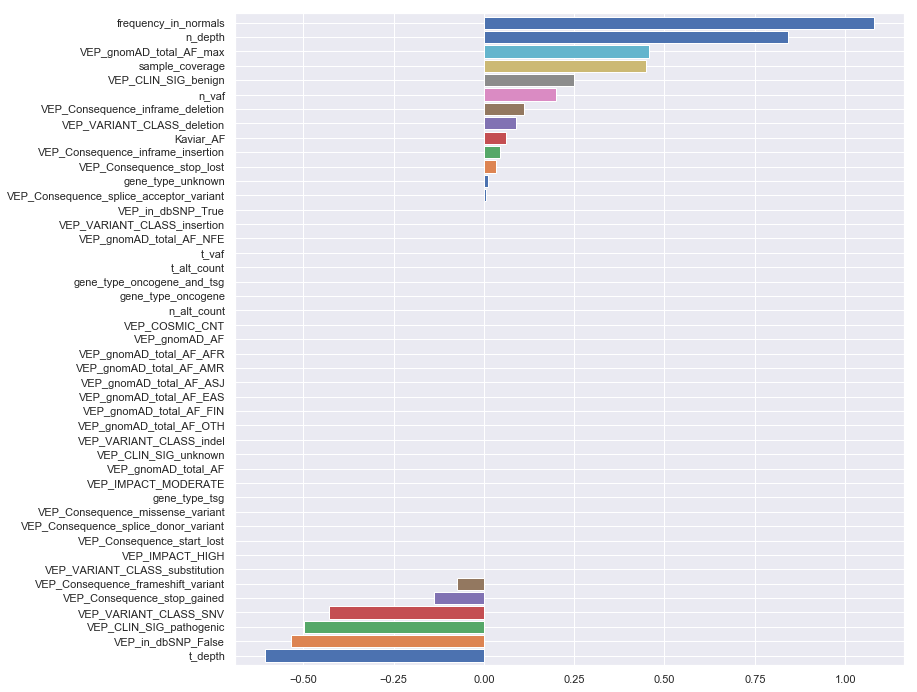

In [43]:
feature_coefficient = pd.DataFrame({'coeff': model.named_steps['classify'].coef_[0]}, index=X.columns.tolist())
feature_coefficient.sort_values(by='coeff', axis=0, inplace=True)

plt.figure(figsize = (12, 12))
feature_coefficient.coeff.plot.barh(width=0.85);

## K Nearest Neighbors

In [51]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < kNN >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

In [52]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < kNN >: </span>✅ job found and reloaded

In [53]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_kNN


<span style="color:green">Job < kNN >: </span>✅ data loaded

In [51]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#parameters_grid = [
#    {'classify__n_neighbors': [5, 10, 20, 25, 30, 40, 50, 60, 100], 'classify__weights': ['uniform', 'distance']}
#]
parameters_grid = [
    {'classify__n_neighbors': [1, 2, 3, 4], 'classify__weights': ['uniform', 'distance']}
]
pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', KNeighborsClassifier())])
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = Metrics(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ../ssh_remote_jobs/job_kNN/script.ipy


In [52]:
job.run(n_jobs=5, short_job=False)

➞ scp ../ssh_remote_jobs/job_kNN to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1384     1.9KB/s   00:00    
metrics.pkl                                   100%  841KB   1.2MB/s   00:00    
script.ipy                                    100% 1080     1.1KB/s   00:00    
X.pkl                                         100% 3268KB   3.2MB/s   00:01    
y.pkl                                         100%   15KB  14.6KB/s   00:01    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_kNN
Job <28643001> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J kNN -n 5 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < kNN >: </span>✅ submitted<br>

In [76]:
job = Selene_Job('kNN', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < kNN >: </span>✅ job found and reloaded

<span style="color:green">Job < kNN >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_kNN to ../ssh_remote_jobs/job_kNN
metrics.pkl                                   100%  490KB   6.0MB/s   00:00    
job_output.txt                                100% 1353   358.6KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.824 ± 0.013
▴ Mean ROC AUC     : 0.905 ± 0.011
▴ Mean F1-score    : 0.812 ± 0.014
▴ Average precision: 0.918 ± 0.010


In [77]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [968.26s | 43.62s]
  → accuracy     : [0.820 | 1.000]
  → ROC AUC      : [0.902 | 1.000]
  → F1-score     : [0.807 | 1.000]
  → avg precision: [0.917 | 1.000]
  → best hyperparameters: {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
Fold 2: [1013.87s | 26.91s]
  → accuracy     : [0.828 | 1.000]
  → ROC AUC      : [0.903 | 1.000]
  → F1-score     : [0.814 | 1.000]
  → avg precision: [0.919 | 1.000]
  → best hyperparameters: {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
Fold 3: [1026.02s | 22.79s]
  → accuracy     : [0.833 | 1.000]
  → ROC AUC      : [0.909 | 1.000]
  → F1-score     : [0.824 | 1.000]


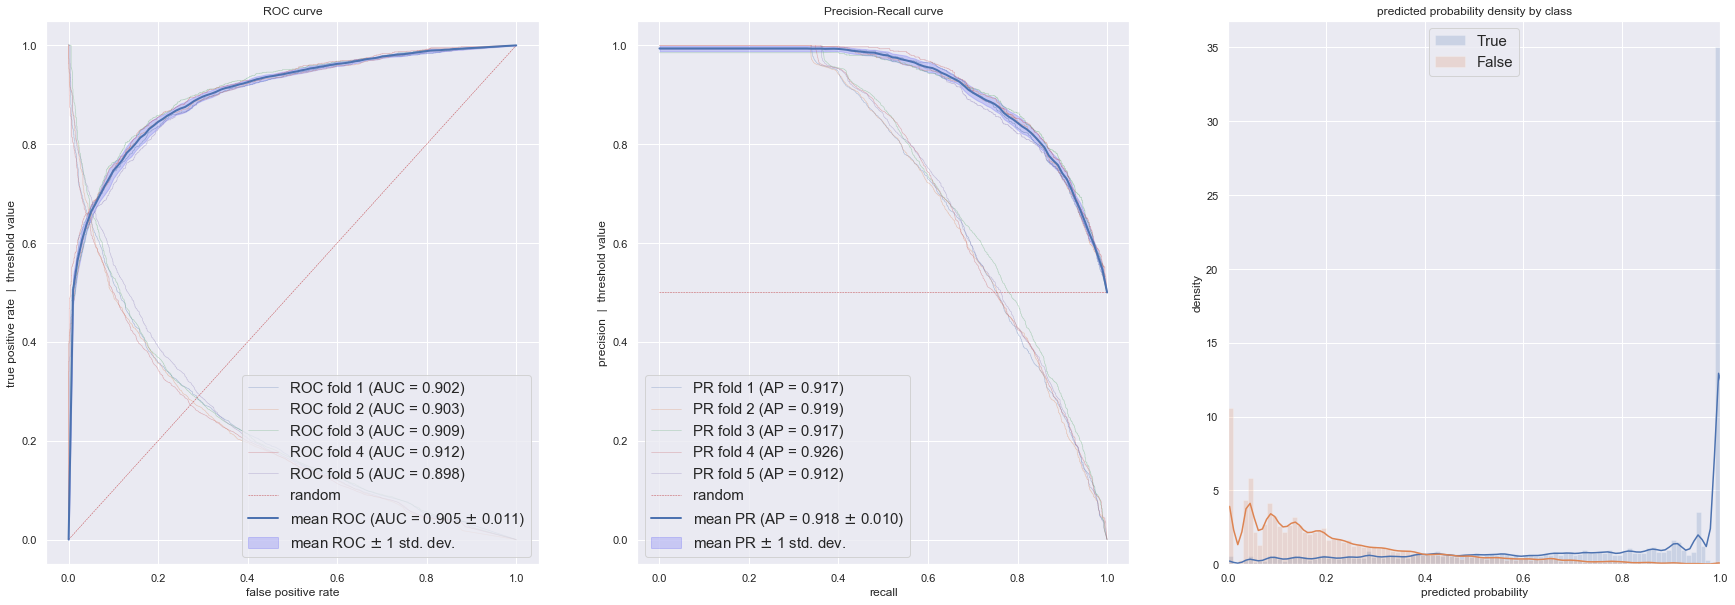

In [78]:
plot_threshold_decision_metrics(job.metrics)

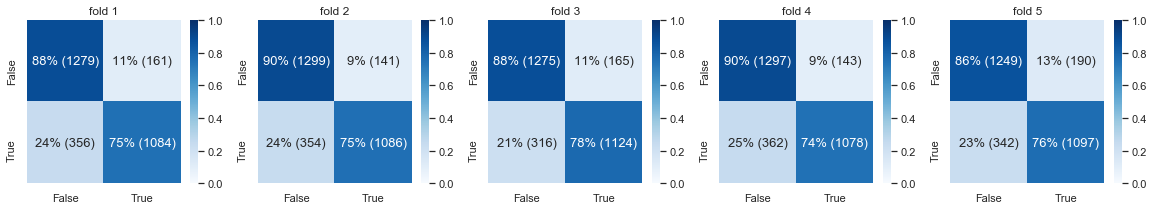

In [79]:
plot_confusion_matrix(job.metrics)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → classify__n_neighbors: [5 10 20 25 30 40 50 60 100]
  → classify__weights    : ['distance' 'uniform']
Best hyperparameters for each fold:
fold 0: {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
fold 1: {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
fold 2: {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
fold 3: {'classify__n_neighbors': 20, 'classify__weights': 'distance'}
fold 4: {'classify__n_neighbors': 20, 'classify__weights': 'distance'}


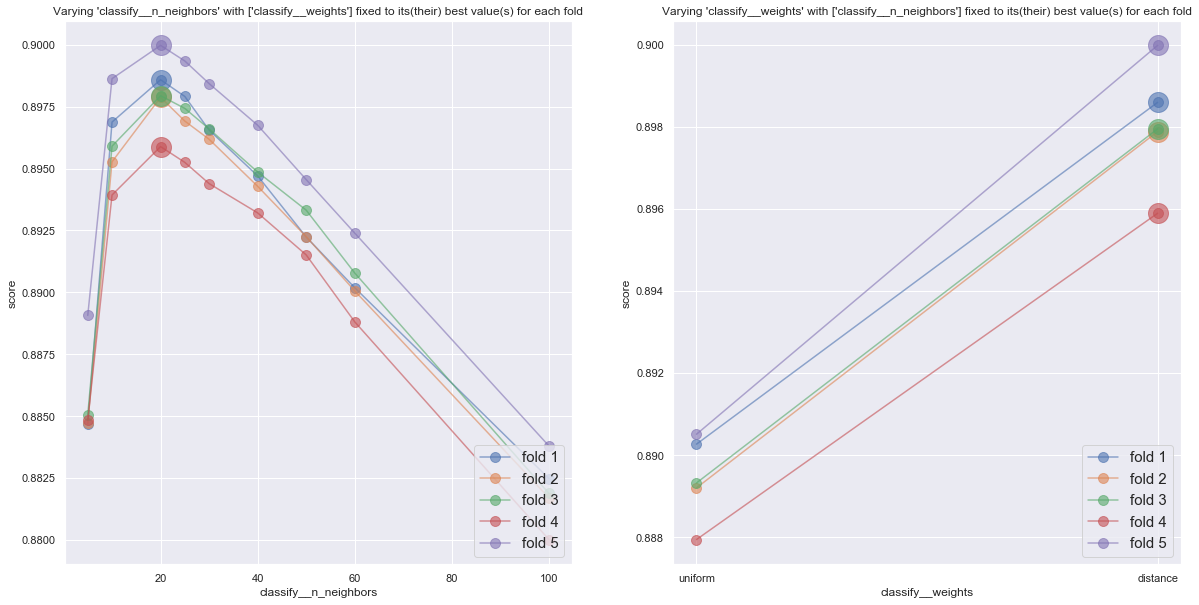

In [80]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [81]:
summary.loc['kNN'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

## Support Vector Machine

In [54]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < SVM >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

In [55]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < SVM >: </span>✅ job found and reloaded

In [56]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_SVM


<span style="color:green">Job < SVM >: </span>✅ data loaded

In [57]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
parameters_grid = [
    {'classify__C': [0.1, 0.8, 0.9, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'classify__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
]
pipe = Pipeline([('scale'   , StandardScaler()),
                 ('classify', SVC(probability=True, cache_size=1000, gamma='scale'))])
model = GridSearchCV(pipe, parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_SVM/script.ipy


In [58]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ../ssh_remote_jobs/job_SVM to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1504     1.5KB/s   00:01    
metrics.pkl                                   100% 1029KB   1.0MB/s   00:01    
script.ipy                                    100% 1102     1.1KB/s   00:01    
X.pkl                                         100% 3268KB   1.6MB/s   00:02    
y.pkl                                         100%   15KB  14.6KB/s   00:01    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_SVM
Job <28643018> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J SVM -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < SVM >: </span>✅ submitted<br>

In [15]:
job = Selene_Job('SVM', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < SVM >: </span>✅ job found and reloaded

<span style="color:green">Job < SVM >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_SVM to ../ssh_remote_jobs/job_SVM
metrics.pkl                                   100%  583KB   5.2MB/s   00:00    
job_output.txt                                100% 1471    51.0KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.838 ± 0.011
▴ Mean ROC AUC     : 0.913 ± 0.009
▴ Mean F1-score    : 0.825 ± 0.012
▴ Average precision: 0.927 ± 0.007


In [16]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [5439.85s | 4.39s]
  → accuracy     : [0.836 | 0.856]
  → ROC AUC      : [0.909 | 0.928]
  → F1-score     : [0.822 | 0.846]
  → avg precision: [0.924 | 0.940]
  → best hyperparameters: {'classify__C': 10, 'classify__kernel': 'rbf'}
Fold 2: [5386.69s | 8.87s]
  → accuracy     : [0.837 | 0.855]
  → ROC AUC      : [0.912 | 0.926]
  → F1-score     : [0.824 | 0.844]
  → avg precision: [0.929 | 0.939]
  → best hyperparameters: {'classify__C': 10, 'classify__kernel': 'rbf'}
Fold 3: [5931.86s | 4.32s]
  → accuracy     : [0.847 | 0.851]
  → ROC AUC      : [0.919 | 0.927]
  → F1-score     : [0.836 | 0.838]
  → avg precision: [0.929 | 0.940]

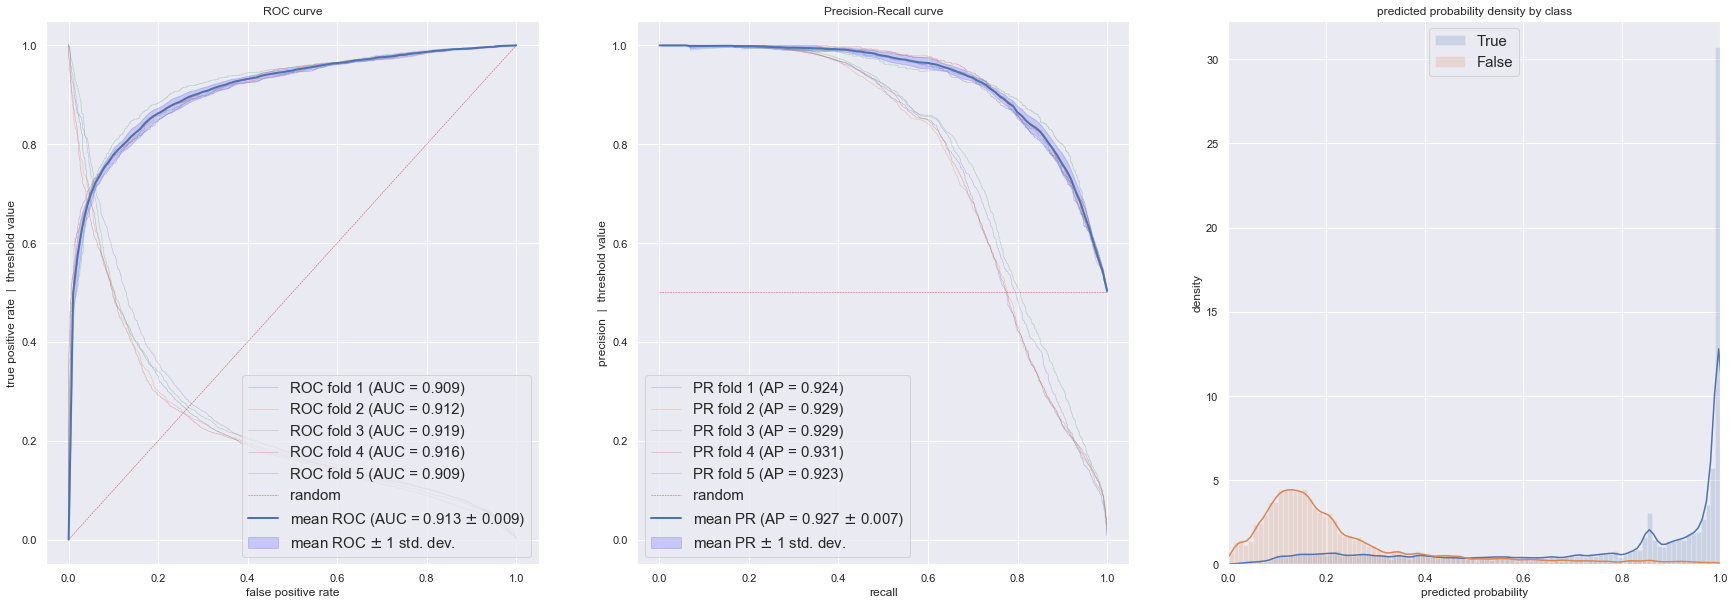

In [17]:
plot_threshold_decision_metrics(job.metrics)

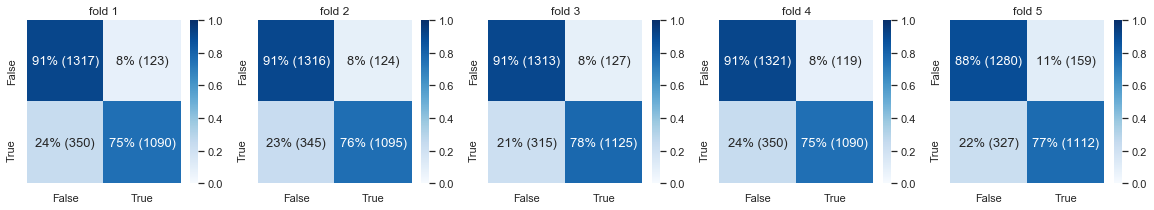

In [18]:
plot_confusion_matrix(job.metrics)

2 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → classify__C     : [0.1 0.8 0.9 1.0 2 3 4 5 6 7 8 9 10]
  → classify__kernel: ['linear' 'poly' 'rbf' 'sigmoid']
Best hyperparameters for each fold:
fold 0: {'classify__C': 10, 'classify__kernel': 'rbf'}
fold 1: {'classify__C': 10, 'classify__kernel': 'rbf'}
fold 2: {'classify__C': 10, 'classify__kernel': 'rbf'}
fold 3: {'classify__C': 10, 'classify__kernel': 'rbf'}
fold 4: {'classify__C': 10, 'classify__kernel': 'rbf'}


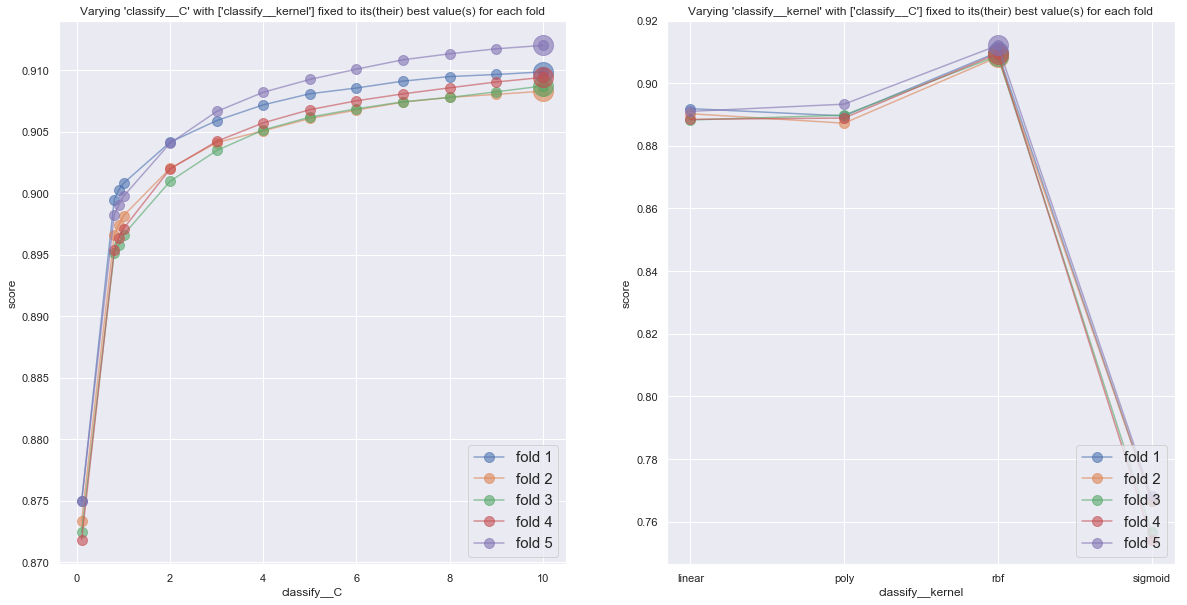

In [19]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [20]:
summary.loc['SVM'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

## Random Forest

### Create job

In [60]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

<span style="color:red">Job < RandomForest >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

In [61]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < RandomForest >: </span>✅ job found and reloaded

In [62]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest


<span style="color:green">Job < RandomForest >: </span>✅ data loaded

In [63]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, 100, 200]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=20)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Overwriting ../ssh_remote_jobs/job_RandomForest/script.ipy


In [64]:
job.run(n_jobs=20, short_job=False, memory=32)

➞ scp ../ssh_remote_jobs/job_RandomForest to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1515     2.4KB/s   00:00    
metrics.pkl                                   100%  931KB   2.2MB/s   00:00    
script.ipy                                    100%  935     0.9KB/s   00:01    
X.pkl                                         100% 3268KB   3.2MB/s   00:01    
y.pkl                                         100%   15KB  94.5KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest
Job <28643029> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest -n 20 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < RandomForest >: </span>✅ submitted<br>

In [82]:
job = Selene_Job('RandomForest', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < RandomForest >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest to ../ssh_remote_jobs/job_RandomForest
metrics.pkl                                   100%  483KB   4.0MB/s   00:00    
job_output.txt                                100% 1501    64.7KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.864 ± 0.008
▴ Mean ROC AUC     : 0.937 ± 0.009
▴ Mean F1-score    : 0.859 ± 0.008
▴ Average precision: 0.948 ± 0.007


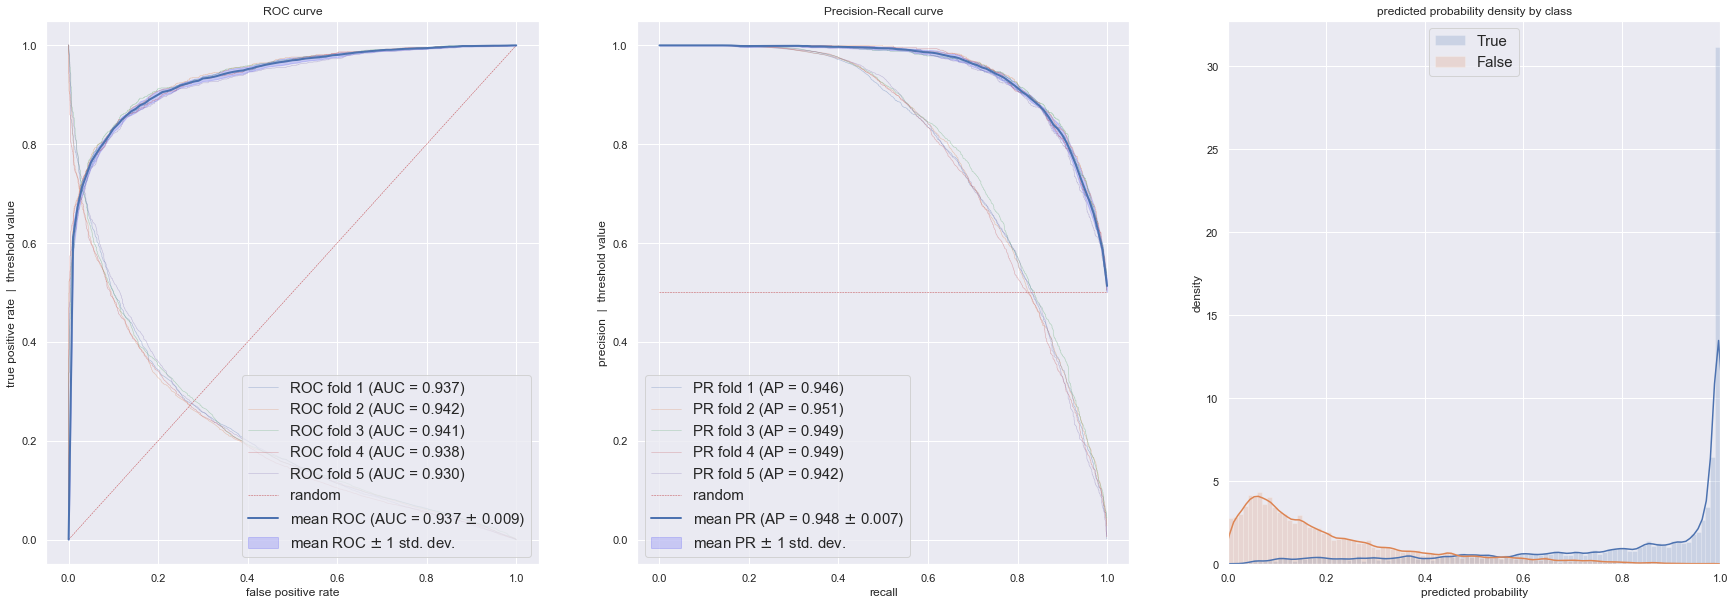

In [83]:
plot_threshold_decision_metrics(job.metrics)

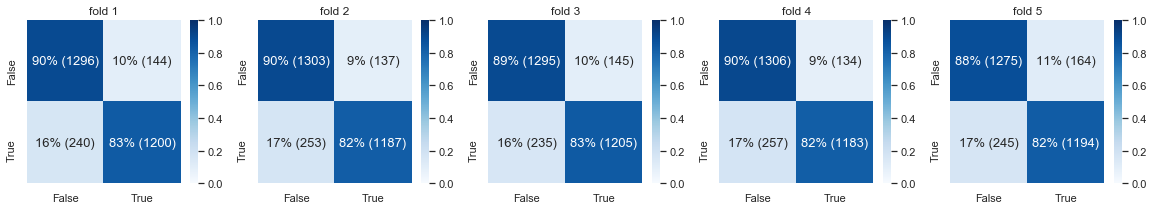

In [84]:
plot_confusion_matrix(job.metrics)

3 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → criterion   : ['entropy' 'gini']
  → max_depth   : [10 20 30 40 50 100 200]
  → n_estimators: [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 1: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1500}
fold 2: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 1000}
fold 3: {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 1500}
fold 4: {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 1000}


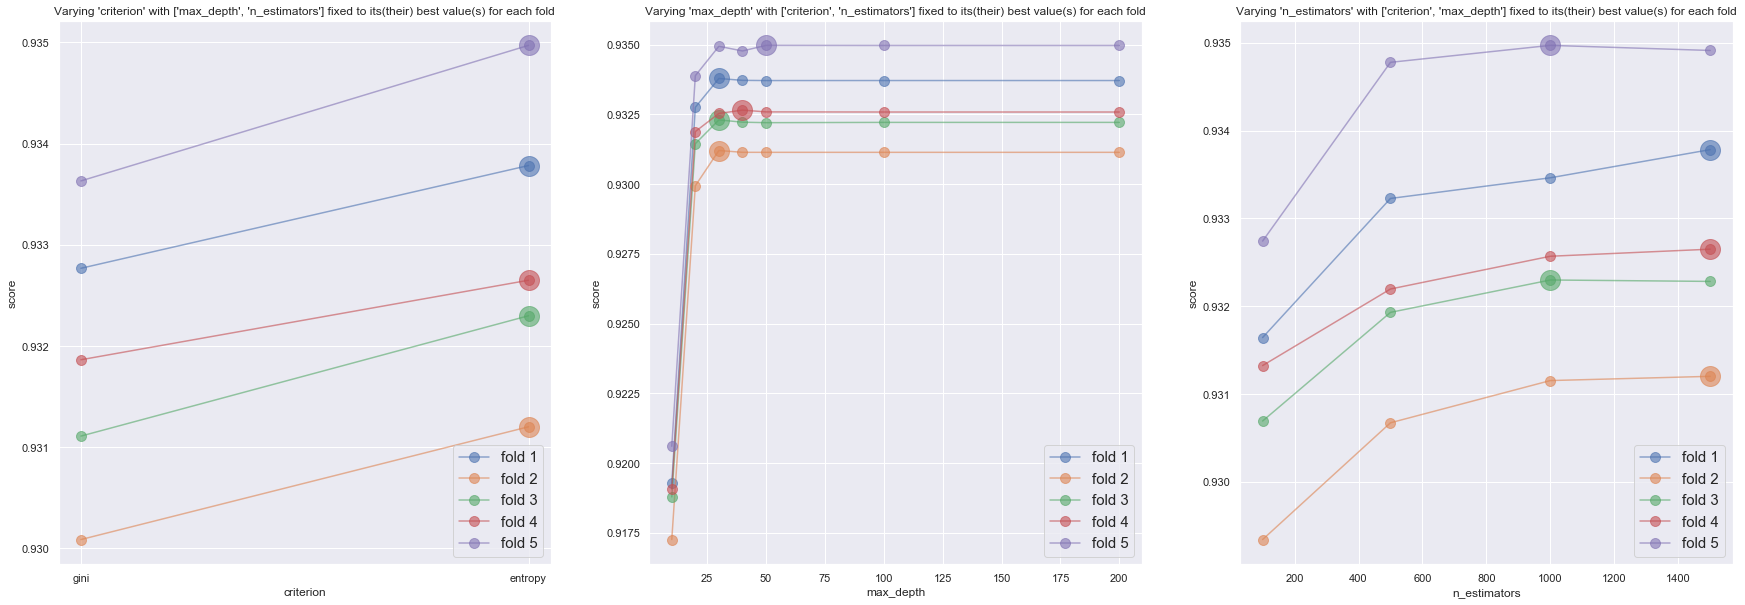

In [85]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [86]:
summary.loc['RandomForest'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)
model_bestRF.fit(X, y);

This is *gini importance* (and not the mean decrease accuracy), see https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined>

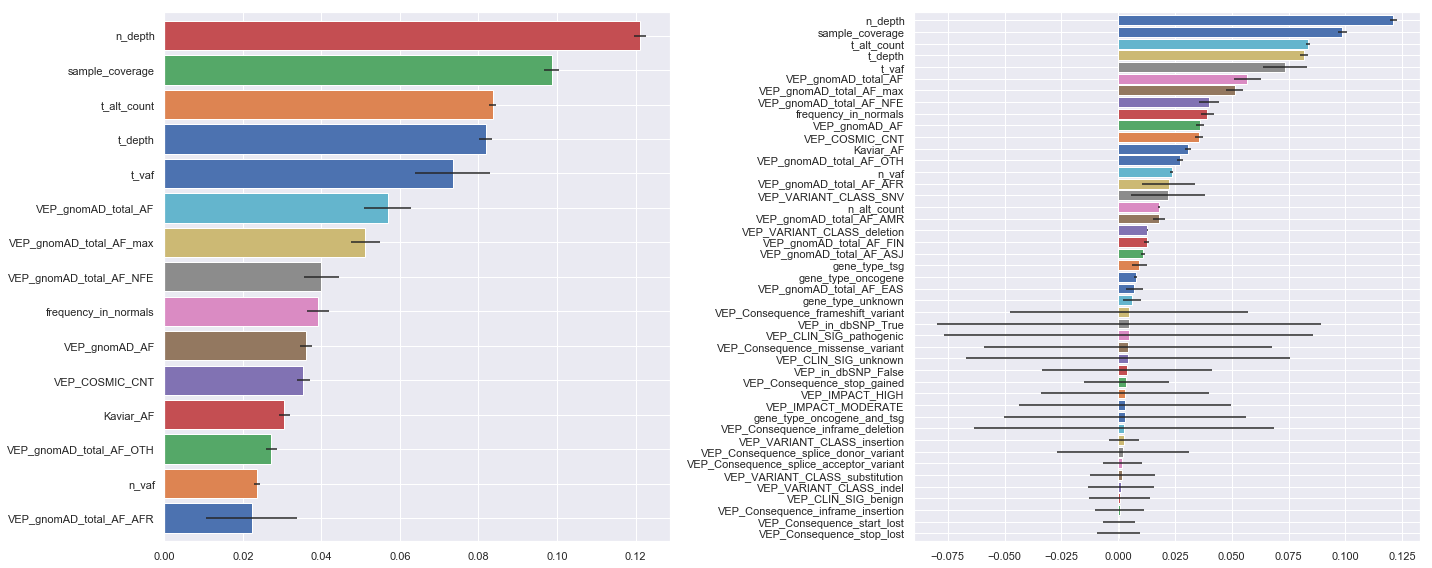

In [67]:
feature_importance = pd.DataFrame({'value': model_bestRF.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

feature_importance['inter_tree_variability'] = np.std([tree.feature_importances_ for tree in model_bestRF.estimators_], axis=0)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85, xerr=feature_importance.tail(15).inter_tree_variability)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85, xerr=feature_importance.inter_tree_variability)
plt.tight_layout()

## Gradient Boosting

### Create job

In [68]:
job = Selene_Job('GradientBoosting2', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

➞ mkdir on local computer ../ssh_remote_jobs/job_GradientBoosting2


<span style="color:green">Job < GradientBoosting2 >: </span>✅ created

In [17]:
job = Selene_Job('GradientBoosting2', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < GradientBoosting >: </span>✅ job found and reloaded

In [70]:
job.load_data(X, y)

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_GradientBoosting2


<span style="color:green">Job < GradientBoosting2 >: </span>✅ data loaded

In [71]:
%%writefile {job.script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'loss': ['deviance', 'exponential'], 'learning_rate': [0.05, 0.08, 0.09, 0.1, 0.11, 0.12, 0.2], 'n_estimators': [100, 500, 1000, 1500], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 20]}
]
model = GridSearchCV(GradientBoostingClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ../ssh_remote_jobs/job_GradientBoosting2/script.ipy


In [72]:
job.run(n_jobs=5, short_job=False, memory=8)

➞ scp ../ssh_remote_jobs/job_GradientBoosting2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100% 1008     2.0KB/s   00:00    
X.pkl                                         100% 3268KB  14.4MB/s   00:00    
y.pkl                                         100%   15KB  29.1KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_GradientBoosting2
Job <28643090> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J GradientBoosting2 -n 5 -R "span[ptile=5,mem=8]" "ipython script.ipy"


<span style="color:green">Job < GradientBoosting2 >: </span>✅ submitted<br>

In [28]:
job = Selene_Job('GradientBoosting2', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job.get_results()

<span style="color:green">Job < GradientBoosting2 >: </span>✅ job found and reloaded

<span style="color:green">Job < GradientBoosting2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_GradientBoosting2 to ../ssh_remote_jobs/job_GradientBoosting2
metrics.pkl                                   100%  972KB   5.9MB/s   00:00    
job_output.txt                                100% 1400   194.8KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.888 ± 0.007
▴ Mean ROC AUC     : 0.954 ± 0.004
▴ Mean F1-score    : 0.885 ± 0.007
▴ Average precision: 0.961 ± 0.005


In [29]:
print_fold_metrics(job.metrics)

Fold #: [fit_time | score_time]
  → accuracy     : [test_accuracy      | train_accuracy     ]
  → ROC AUC      : [test_roc_auc       | train_roc_auc      ]
  → F1-score     : [test_f1_score      | train_f1_score     ]
  → avg precision: [test_avg_precision | train_avg_precision]
  → best hyperparameters: {'first_hyperparameter_name': best_value, ...}

Fold 1: [77451.77s | 0.32s]
  → accuracy     : [0.887 | 0.997]
  → ROC AUC      : [0.956 | 1.000]
  → F1-score     : [0.884 | 0.997]
  → avg precision: [0.962 | 1.000]
  → best hyperparameters: {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 1000}
Fold 2: [76144.49s | 0.35s]
  → accuracy     : [0.883 | 1.000]
  → ROC AUC      : [0.955 | 1.000]
  → F1-score     : [0.880 | 1.000]
  → avg precision: [0.962 | 1.000]
  → best hyperparameters: {'learning_rate': 0.08, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 1000}
Fold 3: [70113.79s | 1.39s]
  → accuracy     : [0.890 | 1.000]
  → ROC AUC      : [0.957 | 1.0

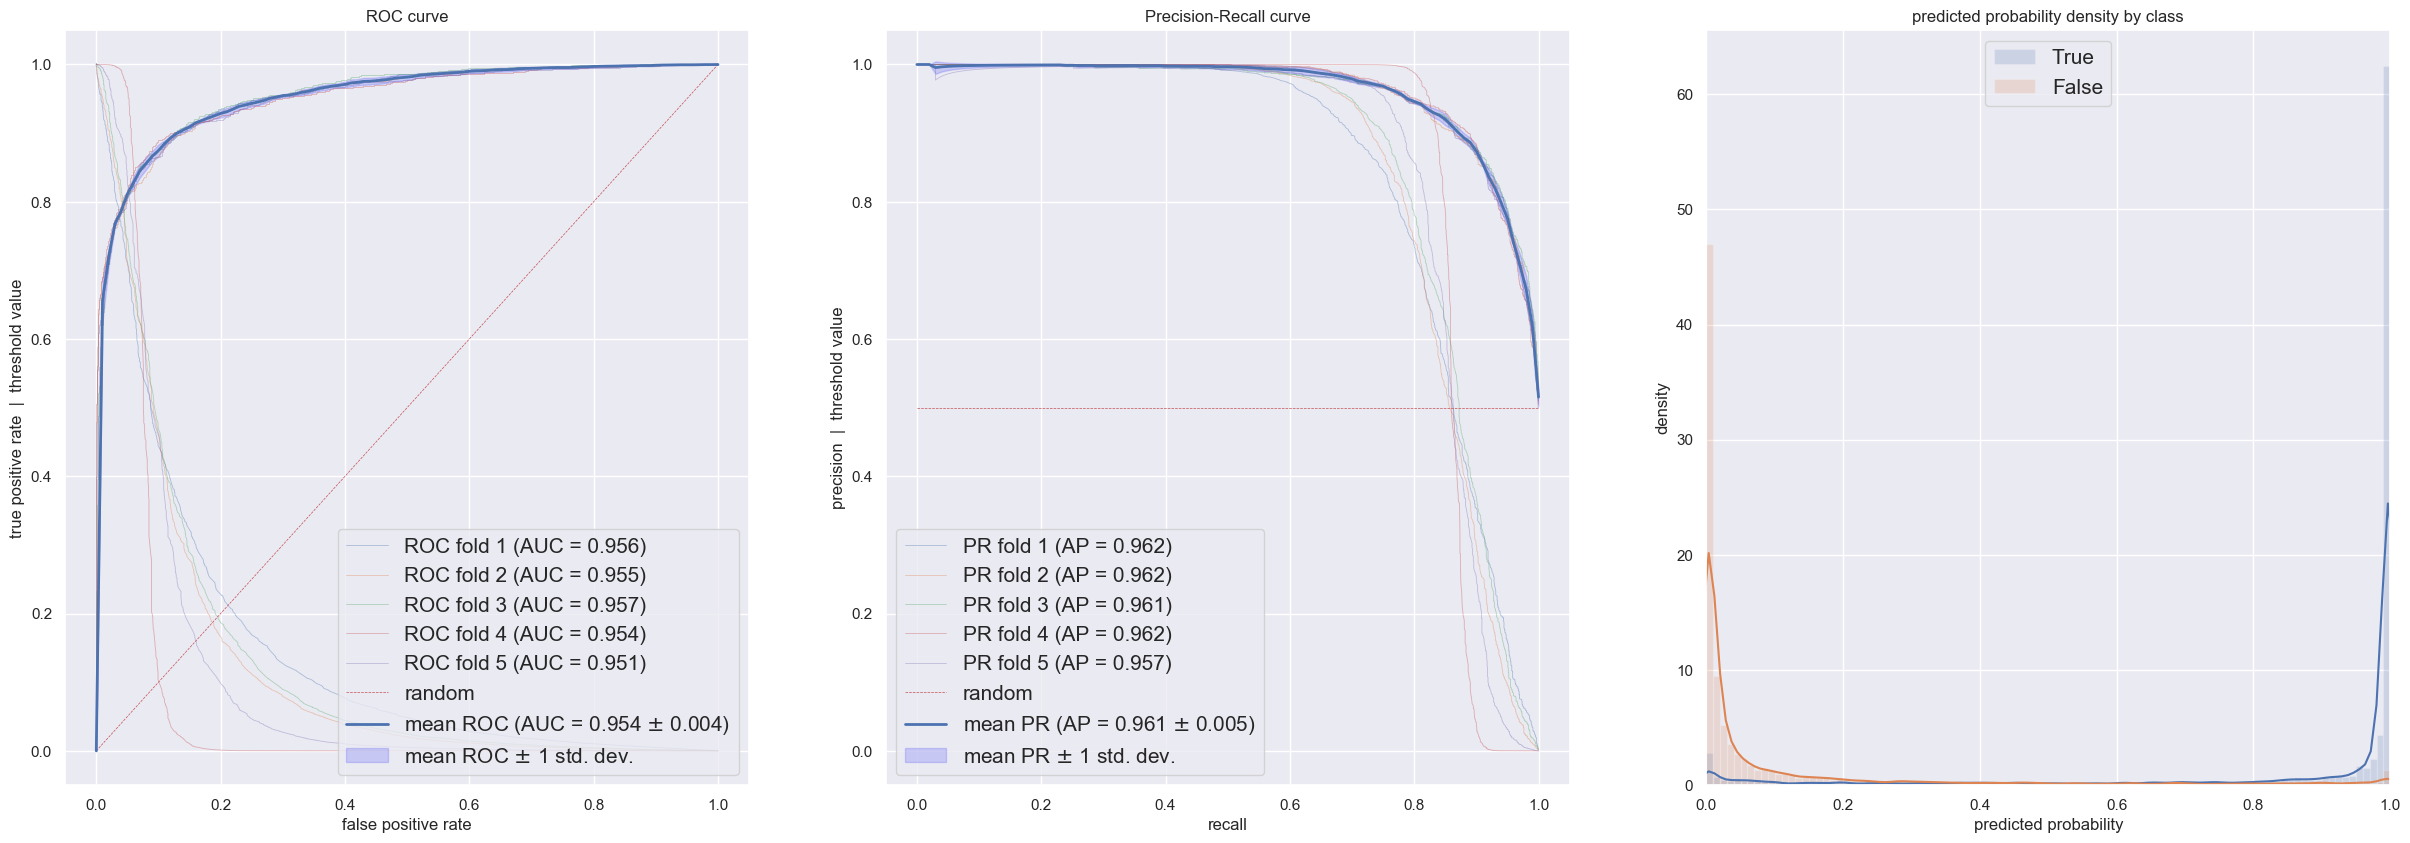

In [30]:
plot_threshold_decision_metrics(job.metrics)

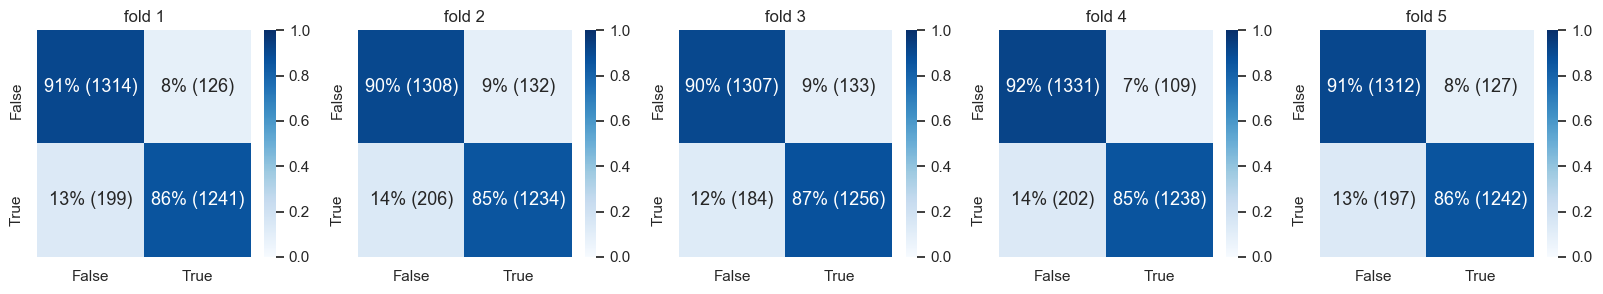

In [31]:
plot_confusion_matrix(job.metrics)

4 hyperparameters tuned for 5 different folds (over a 3-fold nested cross-validation):
  → learning_rate: [0.05 0.08 0.09 0.1 0.11 0.12 0.2]
  → loss         : ['deviance' 'exponential']
  → max_depth    : [4 5 6 7 8 9 10 11 12 20]
  → n_estimators : [100 500 1000 1500]
Best hyperparameters for each fold:
fold 0: {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 1000}
fold 1: {'learning_rate': 0.08, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 1000}
fold 2: {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 6, 'n_estimators': 1500}
fold 3: {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 7, 'n_estimators': 1000}
fold 4: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 7, 'n_estimators': 1000}


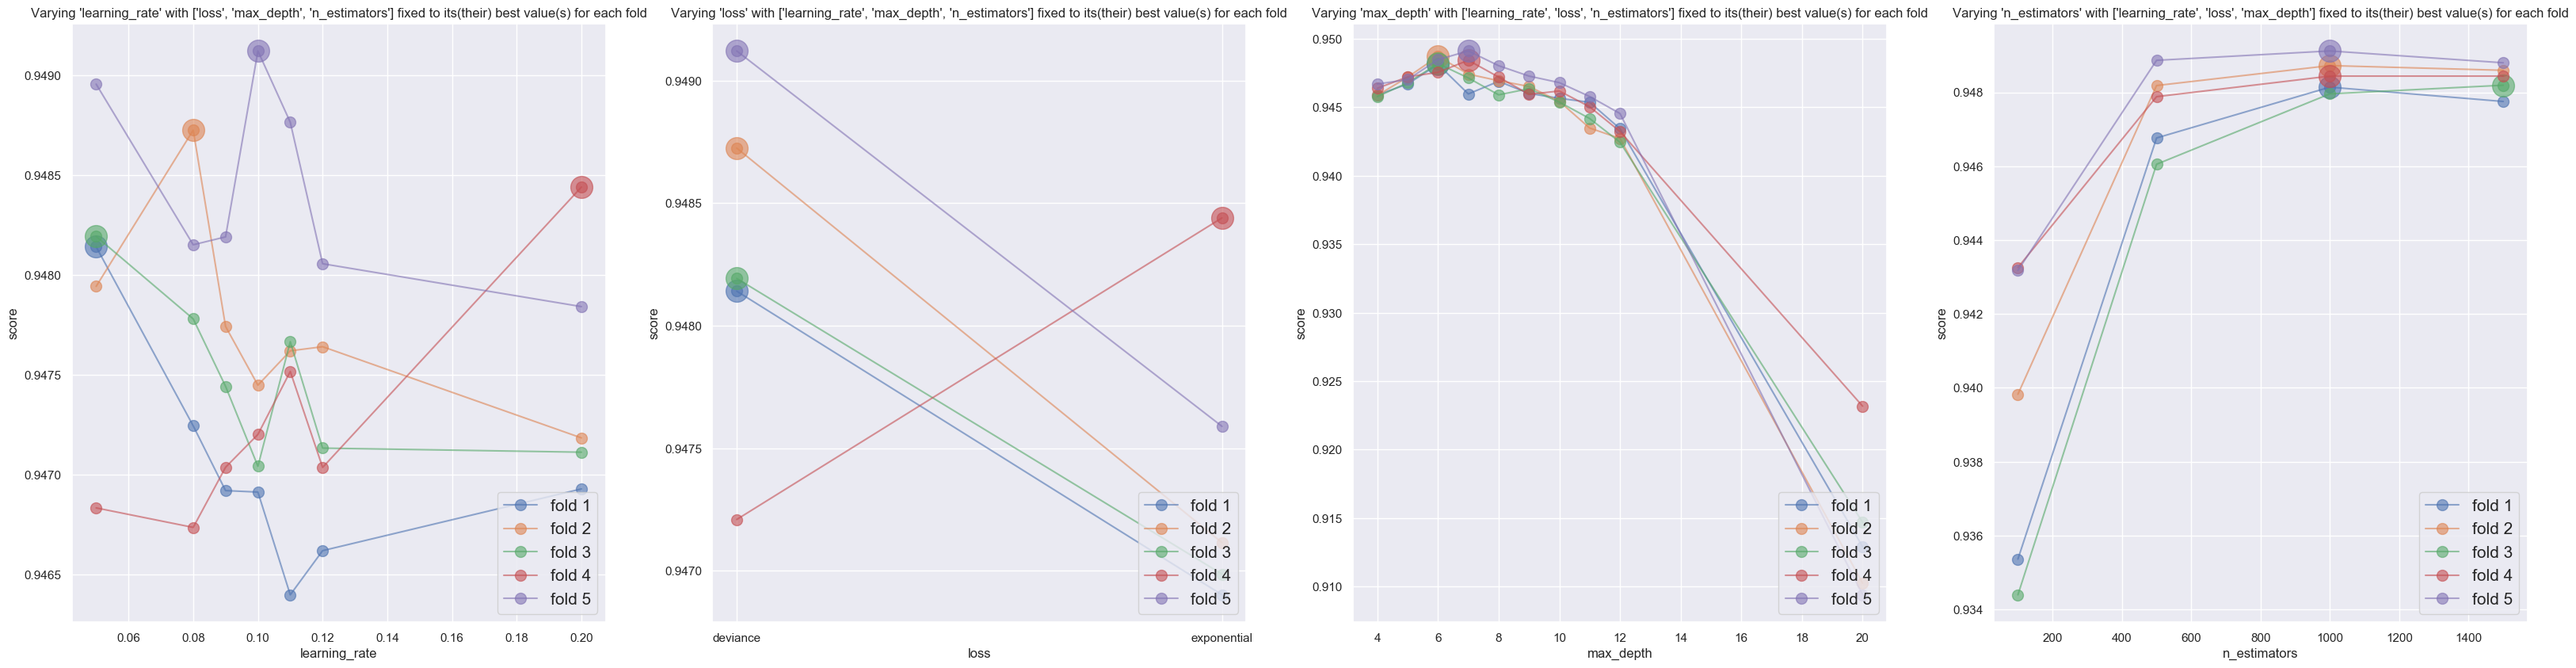

In [32]:
plot_grid_search_results(job.metrics, plot_error_bar = False)

In [37]:
summary.loc['GradientBoosting'] = [job.metrics.test_accuracy.mean(), job.metrics.test_roc_auc.mean(), job.metrics.test_f1.mean(), job.metrics.test_average_precision.mean()]

### Study feature importance of the best hyperparameted classifier

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

model_bestGB = GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=1000, max_depth=10, loss='deviance')
model_bestGB.fit(X, y);

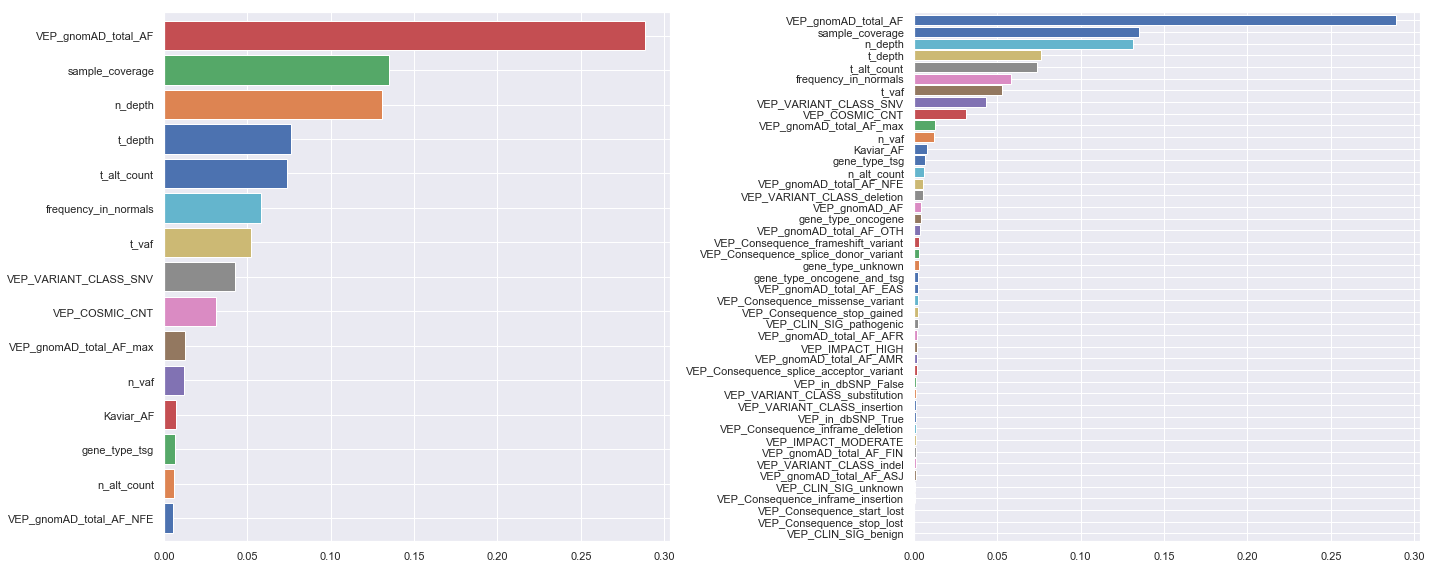

In [75]:
feature_importance = pd.DataFrame({'value': model_bestGB.feature_importances_.tolist()}, index=X.columns.tolist())
feature_importance.sort_values(by='value', axis=0, inplace=True)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
feature_importance.tail(15).value.plot.barh(width=0.85)
plt.subplot(1, 2, 2)
feature_importance.value.plot.barh(width=0.85)
plt.tight_layout()

## Summary

In [27]:
summary = pd.read_pickle('summary.pkl')

,test_accuracy_mean,test_f1_mean,test_roc_auc_mean,test_average_precision_mean
Uniform,0.499,0.497,0.5,0.5
MostFrequent,0.5,0,0.5,0.5
GausssianNaiveBayes,0.721,0.619,0.85,0.872
RidgeRegression,0.82,0.803,0.891,0.912
LassoRegression,0.82,0.804,0.891,0.912
kNN,0.824,0.812,0.905,0.918
SVM,0.838,0.825,0.913,0.927
RandomForest,0.864,0.859,0.937,0.948
GradientBoosting,0.888,0.885,0.954,0.961


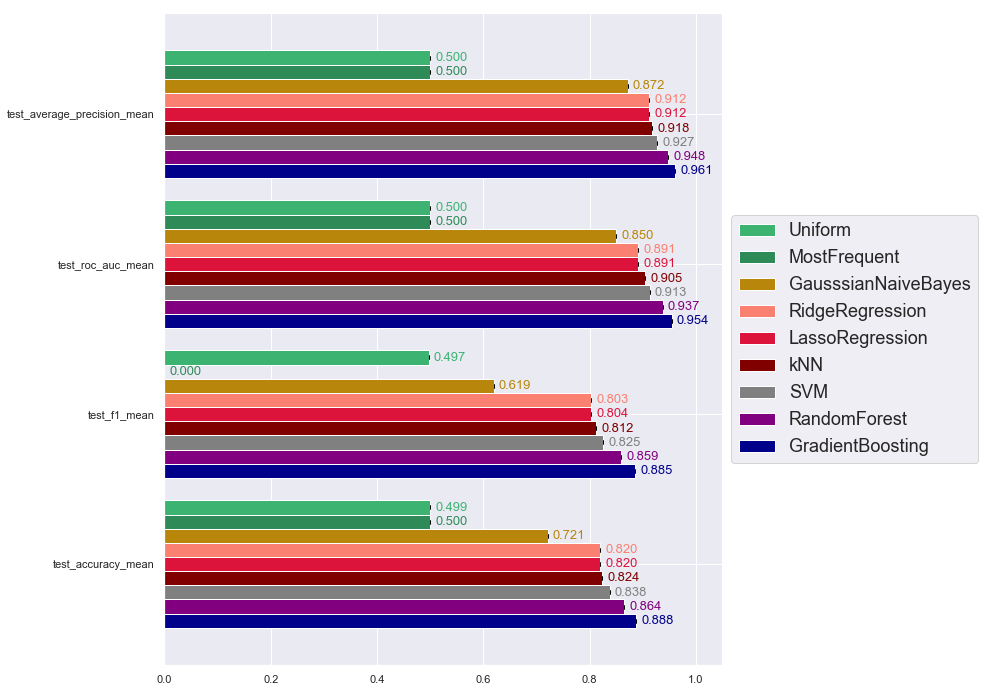

In [31]:
compare_models(summary)

In [3]:
summary_old = pd.read_pickle('summary_old.pkl')

In [14]:
summary_old.columns = ['test_accuracy_mean', 'test_roc_auc_mean', 'test_f1_mean', 'test_average_precision_mean']

,test_accuracy_mean,test_f1_mean,test_roc_auc_mean,test_average_precision_mean
method_name,,,,
Uniform,0.499,0.343,0.5,0.265
MostFrequent,0.735,0,0.5,0.265
GausssianNaiveBayes,0.85,0.625,0.857,0.759
RidgeRegression,0.879,0.728,0.898,0.843
LassoRegression,0.88,0.729,0.898,0.844
kNN,0.878,0.723,0.909,0.848
SVM,0.88,0.725,0.91,0.858
RandomForest,0.904,0.798,0.938,0.897
GradientBoosting,0.913,0.823,0.948,0.912


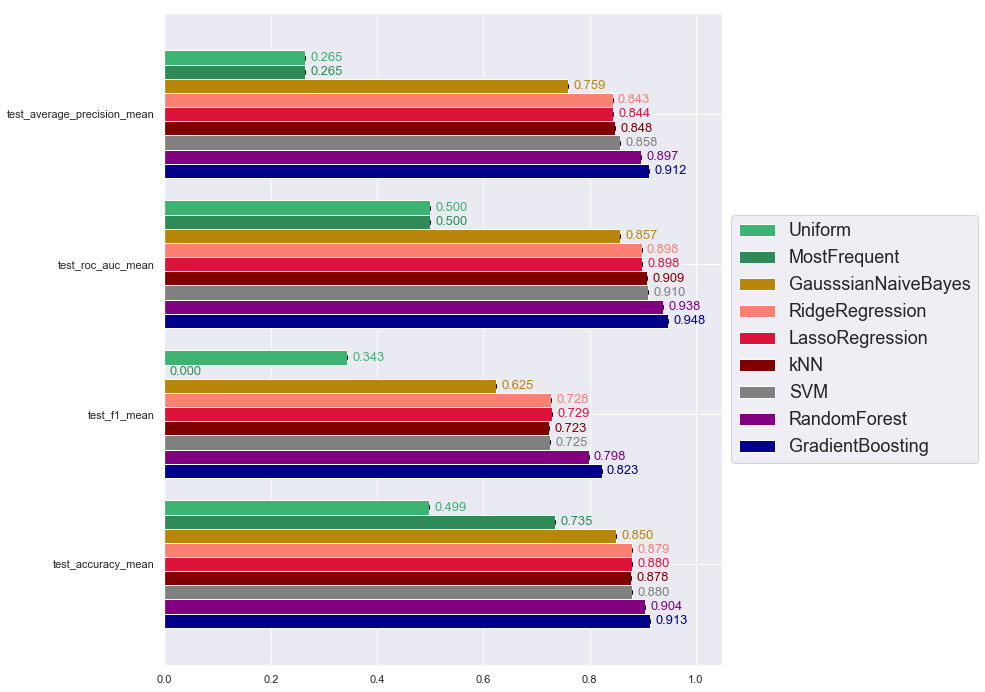

In [25]:
compare_models(summary_old, error_bars=False)